# Food UK - Logistic Regression

- _Author_: Lucas Gonzalez Santa Cruz
- _Workshop_: Data Science Intensive, Springboard.com
- _Date_: 29 September 2016

# tl;dr

_In the UK, since 1974, several thousands of families are selected each year (different families each year). Data is collected about **each family** (about 50 variables: place, number of members of different ages, socioeconomic variables), and about **what each family buys over one week** (3 pints of skimmed milk, 2 pounds sterling; etc). Food items ("brown bread") are categorised into food groups ("breads"). For each food item, 47 **nutrients** are known (calories, vitamin D, etc)._

_I'm interested in food generally, but for this project I will only:_
- _define a score of "shopping-cart goodness" (more fruit+vegs than junk food)_
- _look at how some family variables (income, location, etc) predict a "good cart"_

# Motivation and goals

Food is interesting for many inter-related reasons: food security (poverty, climate change and pandemic disruption), nutritional health ("blue zones"), ecological reasons (edible forests), economic developement (jobs), data and automation (mapping images of fields to help agricultural producers).

Here I'll use one particular dataset with the intention of learning to use some machine language procedures. I will look at what types of food are bought by UK families, and attempt to see how their demographic variables "predict" how healthy is their weekly shopping.

# Data source and datasets

UK families (a different sample each year for many years), have been asked what food they buy for a week.

Data between 1974-2000 is open data:
* Available at http://britains-diet.labs.theodi.org
* Datasets:
    * Households: a file with a line per household, and for each of them 53 variables: number of female adults, male adults and children; income; location; etc. Also, many files translating codes to literals: 11=Scotland, 1=household owner is female, etc.
    * Purchases: a file with a line per food item bought: a certain household bought, over the course of a week, 6 loaves of brown bread (money paid), 3 pints of skimmed milk (money paid), etc.
    * Food groups: several files that put the 300+ food items ("milk", "cheese") into 20+ food groups ("milky products").
    * Nutrients: for each food item (and even for 4 "seasons" each year) there's information about 47 nutrients (calories, vitamin D, etc).

(Data since 2001 is published only in summarised form. We won't be using it here.)

# Data wrangling

* We want one line per household.
* Household variables: household identifier, year, and the other 50+ variables.
* Also for each household: how much of each food they bought.

In [1]:
# ===== IMPORTs, SETTINGS AND FUNCTIONS

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np
import scipy as sp

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, \
                alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, \
                     ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, \
                           cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [2]:
# =============================
# ===== GETTING THE FILES =====
# =============================

#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_2000.zip (etc for all years)
#http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_Reference.zip
data = 'data/'
data2000 = 'data/NFSopen_2000/'
dataRefe = 'data/NFSopen_Reference/'

In [3]:
# ========================================
# ===== FOOD CODES, UNITS AND GROUPS =====
# ========================================

#315 detailed "minor" foodcodes ...
df_min_maj = pd.DataFrame.from_csv(dataRefe+'Ref_ Minor and major foods.txt', sep='\t', index_col=None)
df_min_maj.columns=['minor', 'minor_text', 'major']

#... then aggregated into 184 "major" groups.
df_maj_text = pd.DataFrame.from_csv(dataRefe+'Ref_ Major food codes.txt', sep='\t', index_col=None)
df_maj_text.columns=['major', 'major_text']

#Each "foodcode" (all 315 of them) is described with one of 7 "units": pints, ounces, etc.
df_min_units = pd.DataFrame.from_csv(dataRefe+'Ref_MINFD_Minor_food_codes.txt', sep='\t', index_col=None)
df_min_units.columns=['minor','minor_text','units']
df_min_units.drop(['minor_text'], inplace=True, axis=1) #to avoid duplicate later

#24 more aggregated "groups" were defined, and the 183 previous "detailed groups" were mapped to these 24.
df_grp_text = pd.DataFrame.from_csv(dataRefe+'Ref_ food groups (standard).txt', sep='\t', index_col=None)
df_grp_text.columns=['group','group_text']

#A "mapping" file with 596 rows ...
df_mapping = pd.DataFrame.from_csv(dataRefe+'Ref_ Major-food group mapping.txt', sep='\t', index_col=None)
df_mapping.columns=['major','group']

#... had 92 groups, and those 24 had to be selected.
group24 = [4006, 9017, 22023, 31041, 46094, 100127, 129129, 135148, 150154, 155161, 162171, 172183, \
           184208, 210231, 233248, 251263, 264264, 267277, 281301, 304313, 314339, 340344, 350354, 380389]
df_maj_group = df_mapping[df_mapping['group'].isin(group24) == True] #shape 183x2

# ===== df_groups 315 groups x 6 fields: minor, minor_text, major, major_text, group, group_text
df = pd.merge(df_min_maj, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
df_groups = df

print "Food groups: number, number of variables, variable names", len(df), len(df.columns), list(df.columns.values)

print "\nHere's the number of food codes per group:"
df.groupby('group_text').minor.nunique()

Food groups: number, number of variables, variable names 315 6 ['minor', 'minor_text', 'major', 'major_text', 'group', 'group_text']

Here's the number of food codes per group:


group_text
ALCOHOLIC DRINKS                            10
ALL BREAD                                   22
ALL CARCASE MEAT                            17
ALL FATS                                    17
ALL FISH                                    19
ALL NON-CARCASE MEAT AND MEAT PRODUCTS      50
ALL OTHER FOODS                             23
ALL PROCESSED VEGETABLES                    22
BEVERAGES                                    6
BISCUITS, CAKES, BUNS, CRISPBREADS           7
CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS    33
CONFECTIONERY                                6
EGGS                                         1
FLOUR                                        1
FRESH FRUIT                                 10
FRESH GREEN VEGETABLES                       7
FRUIT & FRUIT PRODS. NOT FRESH               6
LIQUID WHOLEMILK, INC SCHOOL & WELFARE       6
OTHER FRESH VEGETABLES                       8
OTHER MILK & CREAM                          14
POTATOES                                    12
SO

In [4]:
# =========================
# ===== DIARY ENTRIES =====
# =========================

df_purc1995 = pd.DataFrame.from_csv(data+'1995 diary data.txt', sep='\t', index_col=None)
df_purc1995['survyear'] = '1995'
df_purc1996 = pd.DataFrame.from_csv(data+'1996 diary data.txt', sep='\t', index_col=None)
df_purc1996['survyear'] = '1996'
df_purc1997 = pd.DataFrame.from_csv(data+'1997 diary data.txt', sep='\t', index_col=None)
df_purc1997['survyear'] = '1997'
df_purc1998 = pd.DataFrame.from_csv(data+'1998 diary data.txt', sep='\t', index_col=None)
df_purc1998['survyear'] = '1998'
df_purc1999 = pd.DataFrame.from_csv(data+'1999 diary data.txt', sep='\t', index_col=None)
df_purc1999['survyear'] = '1999'
df_purc2000 = pd.DataFrame.from_csv(data+'2000 diary data.txt', sep='\t', index_col=None)
df_purc2000['survyear'] = '2000'
list_of_years = [df_purc1995, df_purc1996, df_purc1997, df_purc1998, df_purc1999, df_purc2000]
df = pd.concat(list_of_years)
df.columns=['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear']
df_diary8 = df

# ===== idem + adding "_text", "group" and "unit" variables
df = pd.merge(df_diary8, df_min_maj, how='left', on='minor')
df = pd.merge(df, df_min_units, how='left', on='minor')
df = pd.merge(df, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')

# ===== DIARY WITH 14, 10 or 6 VARIABLES
df_diary14 = df
df_diary10 = df[['survyear', 'hhno', 'quantity', 'units', 'minor_text', \
                 'group_text', 'minor', 'major', 'major_text', 'group']]
df_diary6  = df[['survyear', 'hhno', 'minor_text', 'quantity', 'units', 'group_text']]
print "DIARY ENTRIES: in 1995-2000, {0:4} families bought {1:6} items, {2:3} foods in {3:2} groups.".\
    format(len(df.hhno.unique()), len(df), len(df.minor_text.unique()), len(df.group_text.unique()))

df = df_diary14
print "variables and variable names:", len(df.columns), list(df.columns.values)

DIARY ENTRIES: in 1995-2000, 42960 families bought 1581381 items, 243 foods in 24 groups.
variables and variable names: 14 ['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear', 'minor_text', 'major', 'units', 'major_text', 'group', 'group_text']


In [5]:
# ======================
# ===== HOUSEHOLDS =====
# ======================

df_hous1995 = pd.DataFrame.from_csv(data+'1995 household data.txt', sep='\t', index_col=None)
df_hous1995['survyear'] = '1995'
df_hous1996 = pd.DataFrame.from_csv(data+'1996 household data.txt', sep='\t', index_col=None)
df_hous1996['survyear'] = '1996'
df_hous1997 = pd.DataFrame.from_csv(data+'1997 household data.txt', sep='\t', index_col=None)
df_hous1997['survyear'] = '1997'
df_hous1998 = pd.DataFrame.from_csv(data+'1998 household data.txt', sep='\t', index_col=None)
df_hous1998['survyear'] = '1998'
df_hous1999 = pd.DataFrame.from_csv(data+'1999 household data.txt', sep='\t', index_col=None)
df_hous1999['survyear'] = '1999'
df_hous2000 = pd.DataFrame.from_csv(data+'2000 household data.txt', sep='\t', index_col=None)
df_hous2000['survyear'] = '2000'

list_of_years = [df_hous1995, df_hous1996, df_hous1997, df_hous1998, df_hous1999, df_hous2000]
df = pd.concat(list_of_years)
print "number of households:", len(df) #len(df.columns), list(df.columns.values)
df_households = df

number of households: 43624


In [6]:
# ===== 53 VARIABLES FOR EACH HOUSEHOLD (+ survyear):
df_house_fields = pd.DataFrame.from_csv(dataRefe+'house-fields.txt', sep='\t', index_col=None)
df_house_fields.columns=['table', 'field', 'field_text', 'type1', 'size', 'type2', 'lookup', 'notes']
df_house_fields = df_house_fields[['field', 'field_text', 'lookup', 'notes']]
house_fields_list = df_house_fields['field'].unique()

In [7]:
# ===== FOODS PER HOUSEHOLD =====
df = df_diary14
df_household_foods = pd.crosstab(df.hhno, df.minor_text, values = df.quantity, aggfunc=np.sum)
df_household_foods = df_household_foods.fillna(0)
df_household_foods.reset_index(level=0, inplace=True)
df = df_household_foods
#print "FOODS PER HOUSEHOLD: shape, number of variables, and variables:", \
#df.shape, len(df.columns), list(df.columns.values)

In [8]:
# ===== FOOD-GROUPS PER HOUSEHOLD =====
df = df_diary14[['hhno', 'quantity', 'group_text']]
df_household_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_groups = df_household_groups.fillna(0)
df_household_groups.reset_index(level=0, inplace=True)
df = df_household_groups
#print "FOOD GROUP PER HOUSEHOLD: shape, number of variables, and variables:",\
#df.shape, len(df.columns), list(df.columns.values)

In [9]:
# ===== HOUSEHOLDS WITH THEIR FOOD-GROUPS =====
df = pd.merge(df_households, df_household_groups, how='left', on='hhno')
df_hh_with_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables."
print "shape and variables:", df.shape, len(df.columns), list(df.columns.values)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 53 demographical variables + 24 food-group variables.
shape and variables: (43624, 78) 78 ['hhno', 'gormet2', 'reg', 'lad', 'styr', 'stmth', 'mic', 'frez', 'owndw', 'memhh', 'schmilk', 'incgp', 'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp', 'pernohoh', 'pernohw', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'stqtr', 'country', 'gor', 'agemdk_banded', 'incgpa', 'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'frij', 'earners', 'occxhoh', 'socxhoh', 'dactxhoh', 'szwkest', 'empst', 'wkdy1rec', 'vegind', 'gornw', 'pernxhoh', 'jobsthoh', 'incgp745', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'ALCOHOLIC DRINKS', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'ALL PROCESSED VEGETABLES', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CEREALS, E

# Logistic regression

## Compute score and classification variable

For each household:
- a score of "good food", say dividing the amount of fruit per the amount of chocolate (or the other way round, depending who you ask!)
- and then a categorisation of that score, say stating that a score higher than 5 is good

In [10]:
# === LOW NUTRITIONAL VALUE:
#'ALCOHOLIC DRINKS'
#'ALL NON-CARCASE MEAT AND MEAT PRODUCTS'
#'ALL OTHER FOODS'
#'BEVERAGES'
#'BISCUITS, CAKES, BUNS, CRISPBREADS'
#'CONFECTIONERY'
#'SOFT DRINKS'
#'SUGAR AND PRESERVES'
# === DOUBT:
#'ALL BREAD' #"WHITE"
#'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS' # (?)
# === REST:
#GENERALLY GOOD FOOD

all_groups = df_grp_text.group_text.tolist()
#all_groups = df_groups.group_text.unique()

bad_groups = ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', \
             'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', \
             'SUGAR AND PRESERVES']

#good_groups = set(all_groups) - set(bad_groups)

good_groups = [x for x in all_groups if x not in bad_groups and x is not np.nan]
print "good groups:", good_groups
print "\nbad groups:", bad_groups
#print "\nall groups:", all_groups

df = df_diary14[['hhno', 'quantity', 'group_text']]
df_good = df[df.group_text.isin(good_groups)]
df_bad = df[df.group_text.isin(bad_groups)]
print "All food purchases split in good and bad:", len(df), len(df_good), len(df_bad)

good groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS']

bad groups: ['ALCOHOLIC DRINKS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']
All food purchases split in good and bad: 1581381 1065193 516188


## 1) Quantities of food

In [11]:
# ===== ADD UP ALL QUANTITIES (EXCEPT HHNO) INTO SUM_GOOD

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

# ===== ADD UP ALL QUANTITIES (EXCEPT HHNO) INTO SUM_BAD

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

GOOD: shape, number of variables, and variables: (43624, 71) 71 ['hhno', 'gormet2', 'reg', 'lad', 'styr', 'stmth', 'mic', 'frez', 'owndw', 'memhh', 'schmilk', 'incgp', 'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp', 'pernohoh', 'pernohw', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'stqtr', 'country', 'gor', 'agemdk_banded', 'incgpa', 'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'frij', 'earners', 'occxhoh', 'socxhoh', 'dactxhoh', 'szwkest', 'empst', 'wkdy1rec', 'vegind', 'gornw', 'pernxhoh', 'jobsthoh', 'incgp745', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL PROCESSED VEGETABLES', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'EGGS', 'FLOUR', 'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', 'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER FRESH VEGETABLES', 'OTHER MILK & CREAM', 'POTATOES', 'TOTAL CHEESE', 'sum_good']

In [12]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(1)
df['how_good'] = df['sum_good'] / df['sum_bad']
df['how_bad'] = df['sum_bad'] / df['sum_good']
df_hh_with_all_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
print "+ variables describing the goodness/badness of their shopping cart."
print "Here's a sample:"
df.head(3)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 53 demographical variables + 24 food-group variables
+ variables describing the goodness/badness of their shopping cart.
Here's a sample:


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL PROCESSED VEGETABLES,"CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,TOTAL CHEESE,sum_good,ALCOHOLIC DRINKS,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS",CONFECTIONERY,SOFT DRINKS,SUGAR AND PRESERVES,sum_bad,how_good,how_bad
0,224203,1.0,0,14,1995,1,1,1,6,3,1.0,1,1.0,220,1.0,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,1.0,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,1.0,1.0,1.0,1.0,0,1995,34.38,15.52,17.63,8.00,114.97,61.70,0.0,0.0,17.12,0.00,0.00,7.0,33.50,7.00,33.6,0.00,350.42,600.0,49.08,12.34,15.86,39.98,0.0,0.00,0.00,717.36,0.488486,2.047143
1,224204,1.0,0,14,1995,1,1,1,5,1,1.0,3,1.0,611,1.0,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,1.0,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,1.0,1.0,1.0,1.0,0,1995,84.63,0.00,0.00,0.00,28.21,3.52,0.0,0.0,0.00,14.00,3.52,0.0,32.00,7.37,80.0,0.00,253.25,200.0,0.00,27.51,1.76,0.00,0.0,70.38,35.27,335.02,0.755925,1.322883
2,224205,1.0,0,14,1995,1,0,0,5,2,1.0,4,1.0,221,1.0,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,1.0,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,1.0,1.0,1.0,1.0,0,1995,93.57,71.23,17.63,19.51,14.81,136.00,12.0,0.0,100.00,24.88,105.58,0.0,85.27,10.67,80.0,8.88,780.03,0.0,55.35,0.00,21.15,42.32,0.0,0.00,47.27,166.19,4.693604,0.213056


In [13]:
print "SUM GOOD"
print df.sum_good.describe()
print len(df[df.sum_good == 0]), "are zero"
print len(df[df.sum_good == np.nan]), "are NaN"

print "\nSUM BAD"
print df.sum_bad.describe()
print len(df[df.sum_bad == 0]), "are zero"
print len(df[df.sum_bad == np.nan]), "are NaN"

print "\nHOW GOOD"
print df.how_good.describe()
print len(df[df.how_good == 0]), "are zero"
print len(df[df.how_good == np.nan]), "are NaN"

print "\nHOW BAD"
print df.how_bad.describe()
print len(df[df.how_bad == 0]), "are zero"
print len(df[df.how_bad == np.nan]), "are NaN"

SUM GOOD
count    43624.000000
mean       457.767722
std        359.387733
min          0.220000
25%        209.847500
50%        396.275000
75%        624.402500
max      13930.670000
Name: sum_good, dtype: float64
0 are zero
0 are NaN

SUM BAD
count    43624.000000
mean       460.089837
std        553.028197
min          0.100000
25%        107.450000
50%        289.045000
75%        621.312500
max      12785.340000
Name: sum_bad, dtype: float64
0 are zero
0 are NaN

HOW GOOD
count    43624.000000
mean         7.017462
std         83.613970
min          0.001171
25%          0.702357
50%          1.320406
75%          2.780680
max      10084.880000
Name: how_good, dtype: float64
0 are zero
0 are NaN

HOW BAD
count    43624.000000
mean         1.555733
std          9.681207
min          0.000099
25%          0.359624
50%          0.757343
75%          1.423778
max        854.170000
Name: how_bad, dtype: float64
0 are zero
0 are NaN


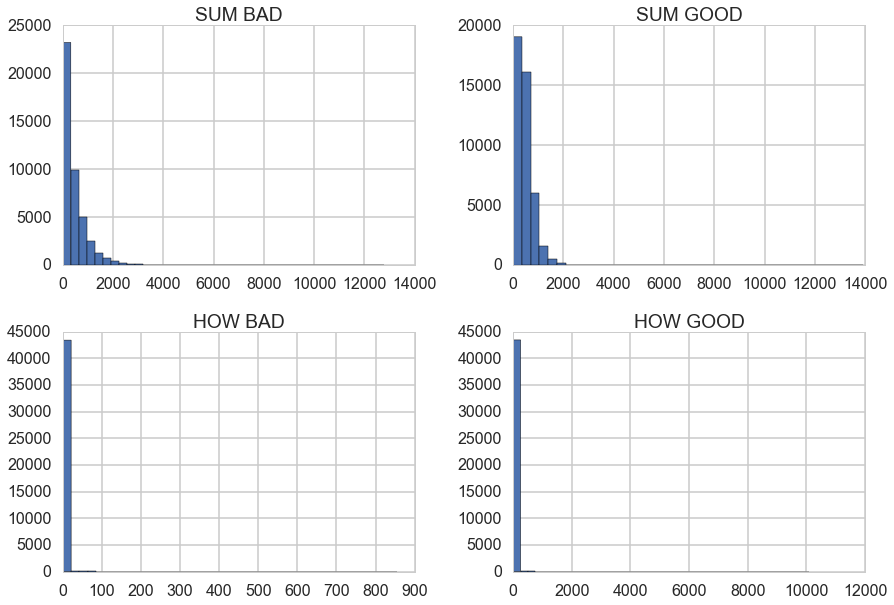

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2)

df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')

plt.tight_layout()

#df.hist(df[['sum_bad', 'sum_good', 'how_bad', 'how_good']],\
#                  column=None, by=None, grid=True, xlabelsize=None, xrot=None, \
#                  ylabelsize=None, yrot=None,\
#                  ax=None, sharex=False, sharey=False,\
#                  figsize=None, layout=None, bins=10) #, **kwds

In [15]:
print df.how_bad.describe()
print df.how_good.describe()

count    43624.000000
mean         1.555733
std          9.681207
min          0.000099
25%          0.359624
50%          0.757343
75%          1.423778
max        854.170000
Name: how_bad, dtype: float64
count    43624.000000
mean         7.017462
std         83.613970
min          0.001171
25%          0.702357
50%          1.320406
75%          2.780680
max      10084.880000
Name: how_good, dtype: float64


## 2) Number of times each food is bought

In [16]:
# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_GOOD

df = df_good
df_household_good_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df
print "GOOD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

# ===== ADD UP ALL TIMES EACH FOOD IS BOUGHT (EXCEPT HHNO) INTO SUM_BAD

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1) # + 0.1 #in 24 cases it's zero, so maybe turn it into 0.1
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df
print "BAD: shape, number of variables, and variables:", df.shape, len(df.columns), list(df.columns.values)

GOOD: shape, number of variables, and variables: (43624, 71) 71 ['hhno', 'gormet2', 'reg', 'lad', 'styr', 'stmth', 'mic', 'frez', 'owndw', 'memhh', 'schmilk', 'incgp', 'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh', 'finctp', 'pernohoh', 'pernohw', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'stqtr', 'country', 'gor', 'agemdk_banded', 'incgpa', 'hhcomp', 'hhcompa', 'hcxigs', 'dat1rec', 'doormilk', 'frij', 'earners', 'occxhoh', 'socxhoh', 'dactxhoh', 'szwkest', 'empst', 'wkdy1rec', 'vegind', 'gornw', 'pernxhoh', 'jobsthoh', 'incgp745', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', 'ALL PROCESSED VEGETABLES', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'EGGS', 'FLOUR', 'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', 'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER FRESH VEGETABLES', 'OTHER MILK & CREAM', 'POTATOES', 'TOTAL CHEESE', 'sum_good']

In [17]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
#len(df[df.how_good.isnull() == True]) #2315
df = df.fillna(0.1)
df['how_good'] = df['sum_good'] / df['sum_bad']
df['how_bad'] = df['sum_bad'] / df['sum_good']
df_hh_with_all_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have survyear + 53 demographical variables + 24 food-group variables"
print "+ variables describing the goodness/badness of their shopping cart."
print "Here's a sample:"
df.head(3)

So we have 1581381 diary entries from 43624 families
and for each family we now have survyear + 53 demographical variables + 24 food-group variables
+ variables describing the goodness/badness of their shopping cart.
Here's a sample:


,hhno,gormet2,reg,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL PROCESSED VEGETABLES,"CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,TOTAL CHEESE,sum_good,ALCOHOLIC DRINKS,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS",CONFECTIONERY,SOFT DRINKS,SUGAR AND PRESERVES,sum_bad,how_good,how_bad
0,224203,0.1,0,14,1995,1,1,1,6,3,0.1,1,0.1,220,0.1,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,0.1,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,0.1,0.1,0.1,0.1,0,1995,2.0,1.0,1.0,1.0,9.0,4.0,0.0,0.0,1.0,0.0,0.0,6.0,2.0,6.0,1.0,0.0,34.0,1.0,5.0,1.0,2.0,4.0,0.0,0.0,0.0,13.0,2.615385,0.382353
1,224204,0.1,0,14,1995,1,1,1,5,1,0.1,3,0.1,611,0.1,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,0.1,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,0.1,0.1,0.1,0.1,0,1995,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,14.0,1.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,8.0,1.750000,0.571429
2,224205,0.1,0,14,1995,1,0,0,5,2,0.1,4,0.1,221,0.1,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,0.1,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,0.1,0.1,0.1,0.1,0,1995,7.0,3.0,1.0,2.0,1.0,8.0,2.0,0.0,3.0,2.0,1.0,0.0,5.0,8.0,1.0,1.0,45.0,0.0,6.0,0.0,2.0,5.0,0.0,0.0,2.0,15.0,3.000000,0.333333


In [18]:
print "SUM GOOD"
print df.sum_good.describe()
print len(df[df.sum_good == 0]), "are zero"
print len(df[df.sum_good == np.nan]), "are NaN"

print "\nSUM BAD"
print df.sum_bad.describe()
print len(df[df.sum_bad == 0]), "are zero"
print len(df[df.sum_bad == np.nan]), "are NaN"

print "\nHOW GOOD"
print df.how_good.describe()
print len(df[df.how_good == 0]), "are zero"
print len(df[df.how_good == np.nan]), "are NaN"

print "\nHOW BAD"
print df.how_bad.describe()
print len(df[df.how_bad == 0]), "are zero"
print len(df[df.how_bad == np.nan]), "are NaN"

SUM GOOD
count    43624.000000
mean        24.419299
std         14.102010
min          0.100000
25%         14.000000
50%         23.000000
75%         33.000000
max        115.000000
Name: sum_good, dtype: float64
0 are zero
0 are NaN

SUM BAD
count    43624.000000
mean        11.837782
std          8.717686
min          0.100000
25%          5.000000
50%         10.000000
75%         17.000000
max         92.000000
Name: sum_bad, dtype: float64
0 are zero
0 are NaN

HOW GOOD
count    43624.000000
mean         4.940854
std         15.289643
min          0.012500
25%          1.500000
50%          2.157895
75%          3.308355
max        530.000000
Name: how_good, dtype: float64
0 are zero
0 are NaN

HOW BAD
count    43624.000000
mean         0.554633
std          1.084573
min          0.001887
25%          0.302265
50%          0.463415
75%          0.666667
max         80.000000
Name: how_bad, dtype: float64
0 are zero
0 are NaN


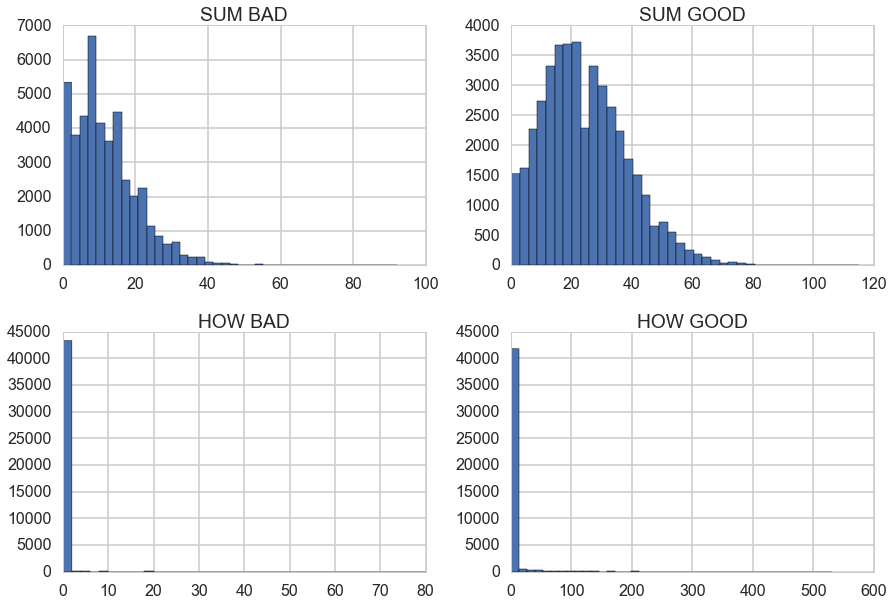

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2)

df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')

plt.tight_layout()

#df.hist(df[['sum_bad', 'sum_good', 'how_bad', 'how_good']],\
#                  column=None, by=None, grid=True, xlabelsize=None, xrot=None, \
#                  ylabelsize=None, yrot=None,\
#                  ax=None, sharex=False, sharey=False,\
#                  figsize=None, layout=None, bins=10) #, **kwds

In [20]:
df = df_hh_with_all_food_groups
df['good_cart'] = df.sum_good > 23 #median
df.good_cart = df.good_cart.astype(int)
df_cat = df
print df_cat.good_cart.value_counts()
df_cat[['hhno', 'sum_good', 'sum_bad', 'how_good', 'how_bad', 'good_cart']].head()

0    22562
1    21062
Name: good_cart, dtype: int64


,hhno,sum_good,sum_bad,how_good,how_bad,good_cart
0,224203,34.0,13.0,2.615385,0.382353,1
1,224204,14.0,8.0,1.750000,0.571429,0
2,224205,45.0,15.0,3.000000,0.333333,1
3,224206,45.0,9.0,5.000000,0.200000,1
4,224207,9.0,7.0,1.285714,0.777778,0


In [21]:
# It looks like I'll have to use
# http://scikit-learn.org/stable/modules/preprocessing.html
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
# sklearn.preprocessing.scale(X, axis=0, with_mean=True, with_std=True, copy=True)[source]
# I guess the matrix would be the 24 groups x 45k observations?

In [22]:
df_house_fields

,field,field_text,lookup,notes
0,hhno,household number,NaN,NaN
1,gormet2,government office region metropolitan county,DCV: GORMET2.txt,Not populated before 1997
2,reg,standard statistical region,DCV: Region.txt,NaN
3,lad,local authority district,DCV: LAD.txt,Northern Ireland from 1996 to 2000
4,styr,statistical year,NaN,NaN
5,stmth,statistical month,NaN,NaN
6,mic,ownership of microwave (1 = yes 0= not),DCV: Microwave ownership.txt,Not used before 1989
7,frez,ownership of freezer (1 = yes 0= not),DCV: Freezer ownership.txt,NaN
8,owndw,tenure (ownership of dwelling),DCV: Ownership of dwelling.txt,Coding changed from 1997 on to include squatting
9,memhh,number of members of the household,NaN,This field has been top-coded to remove all ho...


In [23]:
print house_fields_list
#hhno
fields_candidate = ['reg', 'styr', 'mic', 'frez', 'owndw', 'memhh', 'incgp',\
                    'occhoh', 'sochoh', 'dacthoh', 'Finc_decile_by_members_of_hh',\
                    'finctp', 'agehoh_banded', 'agehw_banded', 'adltm', 'adltf',\
                    'child', 'oaps', 'adltgt64', 'agemdk_banded', 'frij', 'earners',\
                    'empst', 'vegind', 'benefits']
fields_candidate_strong = ['reg',\
                           'mic', 'frez', 'frij', 'owndw',\
                           'adltm', 'adltf', 'child', 'oaps', 'adltgt64',\
                           'earners', 'benefits']

['hhno' 'gormet2' 'reg' 'lad' 'styr' 'stmth' 'mic' 'frez' 'owndw' 'memhh'
 'schmilk' 'incgp' 'occhoh' 'sochoh' 'dacthoh'
 'Finc_decile_by_members_of_hh' 'finctp' 'pernohoh' 'pernohw'
 'agehoh_banded' 'agehw_banded' 'adltm' 'adltf' 'child' 'oaps' 'adltgt64'
 'stqtr' 'country' 'gor' 'agemdk_banded' 'incgpa' 'hhcomp' 'hhcompa'
 'hcxigs' 'dat1rec' 'doormilk' 'frij' 'earners' 'occxhoh' 'socxhoh'
 'dactxhoh' 'szwkest' 'empst' 'wkdy1rec' 'vegind' 'gornw' 'pernxhoh'
 'jobsthoh' 'incgp745' 'withjob' 'landlord' 'furnish' 'benefits']


In [24]:
selected_fields = fields_candidate_strong
selected_fields.insert(0,'hhno')
selected_fields.insert(1,'good_cart')

In [25]:
print selected_fields

['hhno', 'good_cart', 'reg', 'mic', 'frez', 'frij', 'owndw', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'earners', 'benefits']


In [26]:
df = df_cat[selected_fields]
df.describe() #head()

,hhno,good_cart,reg,mic,frez,frij,owndw,adltm,adltf,child,oaps,adltgt64,earners,benefits
count,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000,43624.000000
mean,245955.482074,0.482808,5.783193,0.782047,0.917133,0.031082,4.421809,0.886301,0.986980,0.634994,0.272052,0.352558,1.107235,0.120690
std,12894.572339,0.499710,3.168619,0.412860,0.275685,0.046283,1.947888,0.583846,0.485363,1.031150,0.556533,0.639743,0.985956,0.325771
min,100136.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,235093.750000,0.000000,3.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,246000.500000,0.000000,6.000000,1.000000,1.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,256907.250000,1.000000,9.000000,1.000000,1.000000,0.100000,6.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000
max,267819.000000,1.000000,10.000000,1.000000,1.000000,0.100000,7.000000,5.000000,7.000000,8.000000,4.000000,4.000000,6.000000,1.000000


In [27]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(df[['reg','child']].values, (df.good_cart==1).values,random_state=5)

In [28]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [29]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print accuracy_score(clf.predict(Xtestlr),ytestlr)

0.625252154777


In [30]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print score

0.617397066127


In [31]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr,ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    print "C and score: ", c, score
print "(select C with maximum score, i.e. C=...) ... THEY ARE ALL THE SAME :-?"

C and score:  0.001 0.617397151415
C and score:  0.1 0.617397151415
C and score:  1 0.617397151415
C and score:  10 0.617397151415
C and score:  100 0.617397151415
(select C with maximum score, i.e. C=...) ... THEY ARE ALL THE SAME :-?


In [32]:
clf = LogisticRegression(C=0.001)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print(accuracy)

0.625252154777


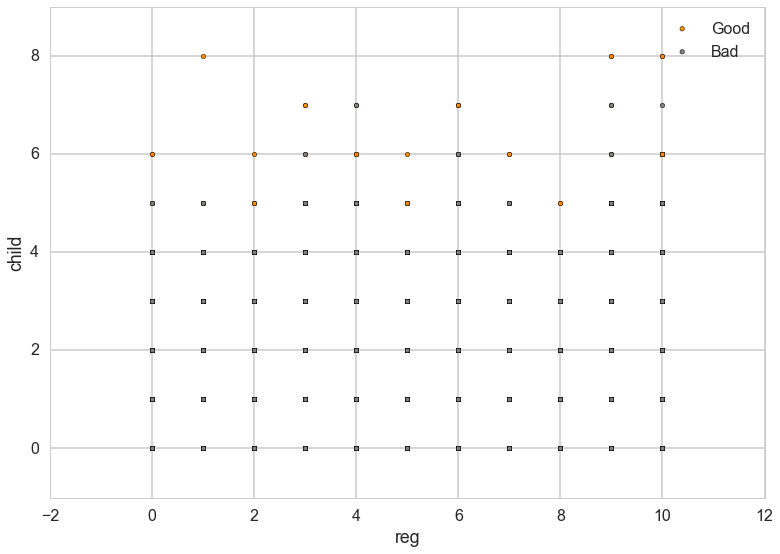

In [33]:
ax = df[df.good_cart == 1].plot.scatter(x='reg', y='child', color='DarkOrange', label='Good');
df[df.good_cart == 0].plot.scatter(x='reg', y='child', color='Grey', label='Bad', ax=ax);

In [34]:
from sklearn import grid_search
clf = grid_search.GridSearchCV(LogisticRegression(C=1), param_grid = {'C':[0.001, 0.1, 1, 10, 100]})
clf.fit(Xlr, ylr)
#print "best parameter:", clf.best_params_
#print "with a score of:", clf.best_score_
#print "From this grid of scores:"
#clf.grid_scores_

#print "Grid scores:"
#for params, mean_score, scores in clf.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean_score, scores.std() * 2, params))
# ??? why *2?

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [35]:
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print("Accuracy: %f" % accuracy)

Accuracy: 0.625252


In [36]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [37]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

In [38]:
# DISCUSSION
## MAIN FINDINGS
## LIMITATIONS
## WHAT NEXT